# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.3.0+cpu'

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 60

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_orig import StaticReacherProxy, N_REWARDS
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

from utils.gahil import GAHIL
GAN_REWARD = GAHIL(action_size=ACTION_SIZE)

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        idx = []
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step, n_so, a) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps, states_1, actions)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1
                
            #if do_her: idx.append(i)
            #elif rewards[i] > 0: idx.append(i)
            
            if rewards[i] > 0: idx.append(i)

            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()

        if len(idx) > 1: GAN_REWARD.register_target(#old design to work over numpy
            states[idx].numpy(), states_1[idx].numpy(), goals[idx].numpy(), actions[idx].numpy())
        
        gahil = GAN_REWARD.register_other_with_reward(#old design to work over numpy
                states.numpy(), states_1.numpy(), h_goals.numpy(), actions.numpy()) / 100.
        
        return ( gahil, h_goals, states, h_n_goals, n_states )
    
def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, lr_critic,
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]
#        cind = i, gae=True, n_step=4, floating_step=False, gamma=.99, gae_tau=.95, her_delay=None) for h in her ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=3, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=lr_critic, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 6, batch_size=BS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 20) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=2*MAX_STEPS, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
BS = 512
PPOBS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 5, batch_size=PPOBS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 10) // 3,
            optim_epochs=1, optim_batch_size=1*PPOBS,  recalc_delay=3,
            
            lr_actor=1e-3, learning_delay=1*MAX_STEPS, learning_repeat=6,
            sync_delta_a=3, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=True),

        BrainDescription(
            memory_size=20 * MAX_STEPS * 200, batch_size=BS, 
            optim_pool_size=70000, optim_epochs=2, optim_batch_size=3*BS, recalc_delay=5,
            lr_actor=3e-5, learning_delay=10, learning_repeat=4,
            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=True, ppo_eps=None, natural=False, mean_only=True, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[6000, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 16000, '<- optim_pool_size;', 3, '<- recalc_delay;', 3, '<- sync_delta_a;', 1, '<- sync_delta_c;', 60, '<- learning_delay;', 6, '<- learning_repeat;', 0.001, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [240000, '<- memory_size;', 512, '<- batch_size;', 2, '<- optim_epochs;', 1536, '<- optim_batch_size;', 70000, '<- optim_pool_size;', 5, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 4, '<- learning_repeat;', 3e-05, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', None, '<- ppo_eps;', False, '<- natural;', True, '<- mean_only;']]


## 9. LEARN!

HER IS TURNED OFF!!
HER IS TURNED OFF!!


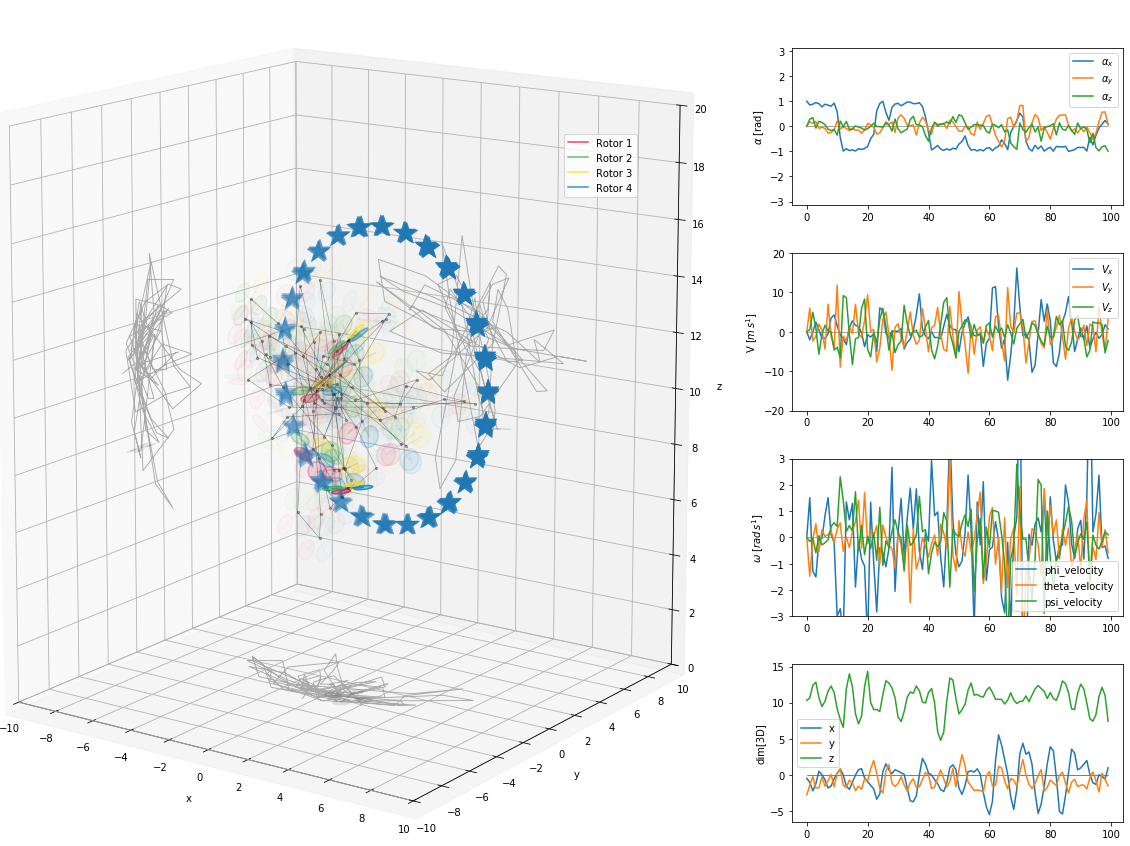

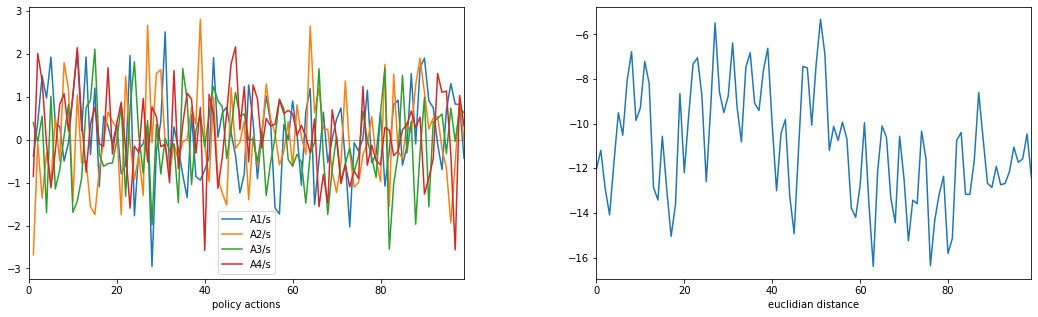

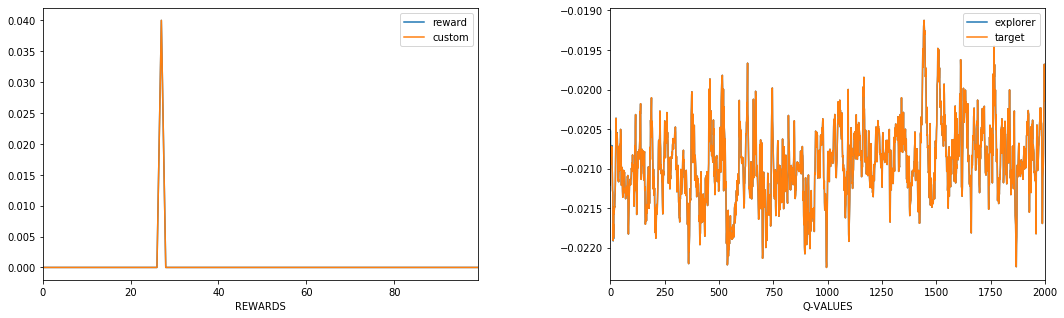

[   19>  1139:: 0] steps =   59, max_step =  60/ 60, reward=0.051500 <action=tensor([ 5.7746,  8.5690, -3.4515,  3.4606])>                                    
	 [ 19 ] < 276.09 sec > TEST ==>  [[tensor(0.7255)], [tensor(0.6485)]] exploring score: tensor(0.0545)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   168.83ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   168.80ms/cyc @     0.3execs/cyc
                    learn: 100.0%   168.79ms/cyc @     0.3execs/cyc
        FullMemory-sample:  75.4%   127.27ms/cyc @     0.1execs/cyc
            _push_to_fast:  62.6%   105.68ms/cyc @    15.3execs/cyc
                 __call__:  28.7%    48.47ms/cyc @    15.7execs/cyc
                   _learn:  27.1%    45.78ms/cyc @     0.4execs/cyc
        FastMemory-sample:  24.6%    41.46ms/cyc @     0.2execs/cyc
                 backprop:  12.4%    20.97ms/cyc @     0.8execs/cyc
                    _push:   3.0%     5.10ms/cyc @     0.3execs/cyc
             

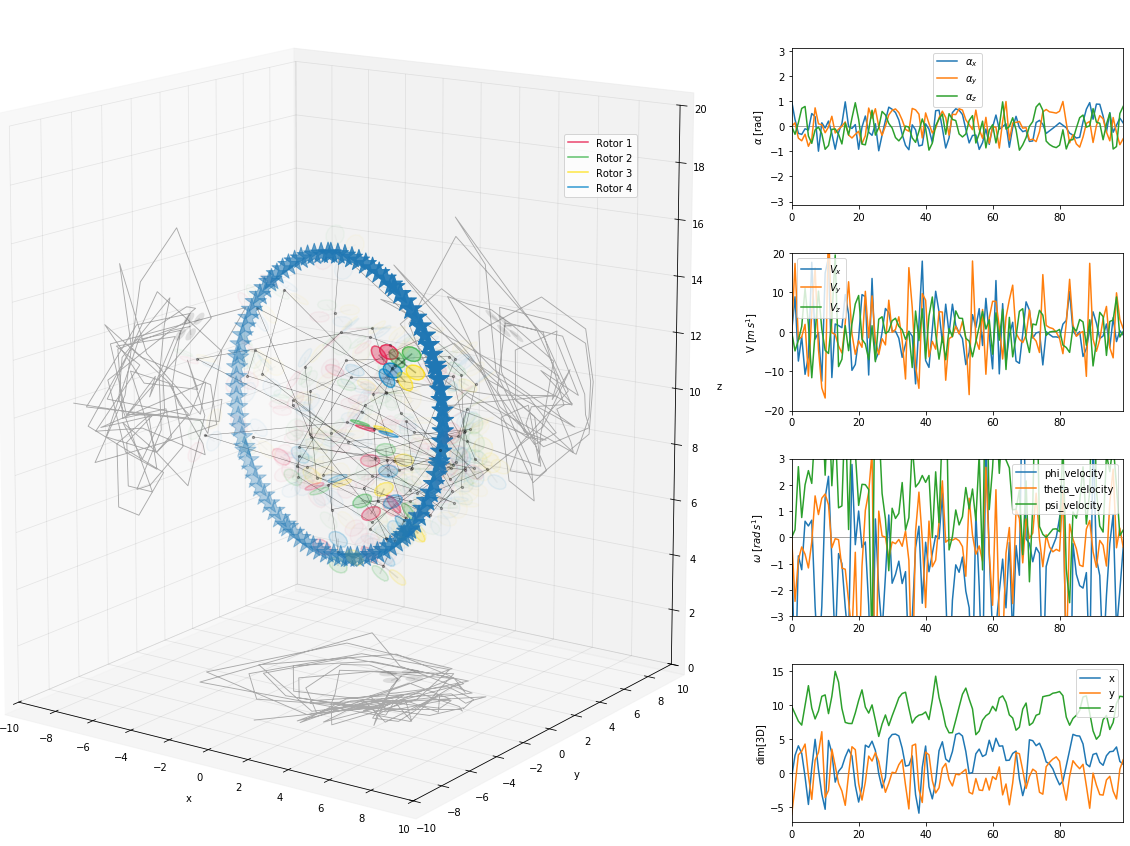

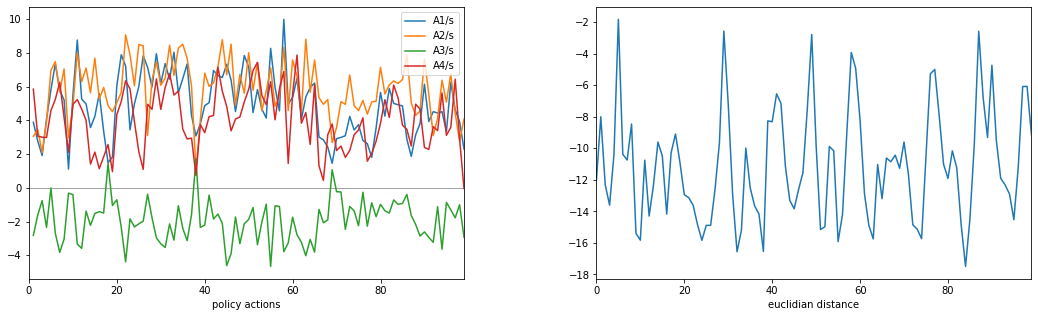

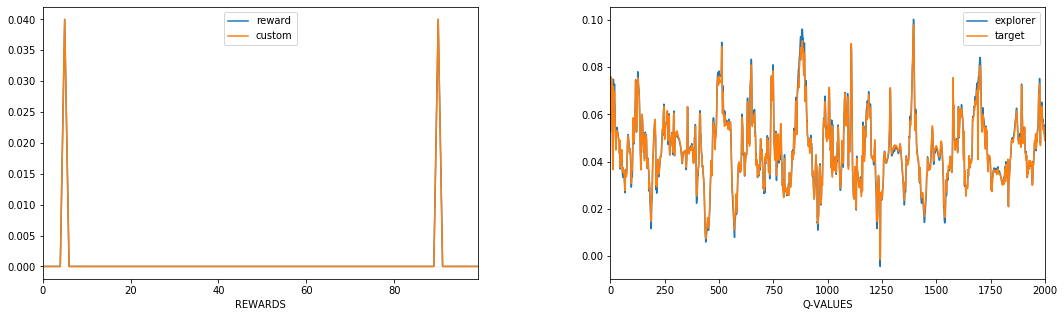

[   39>  2339:: 0] steps =   59, max_step =  60/ 60, reward=0.052500 <action=tensor([ 3.9677,  5.7508, -1.6187,  2.3317])>                                    
	 [ 39 ] < 570.68 sec > TEST ==>  [[tensor(0.7725)], [tensor(0.7775)]] exploring score: tensor(0.0525)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   180.75ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   180.72ms/cyc @     0.3execs/cyc
                    learn: 100.0%   180.71ms/cyc @     0.3execs/cyc
        FullMemory-sample:  75.0%   135.48ms/cyc @     0.1execs/cyc
            _push_to_fast:  62.3%   112.52ms/cyc @    16.3execs/cyc
                 __call__:  28.5%    51.50ms/cyc @    16.6execs/cyc
                   _learn:  27.4%    49.45ms/cyc @     0.4execs/cyc
        FastMemory-sample:  25.0%    45.16ms/cyc @     0.2execs/cyc
                 backprop:  12.5%    22.68ms/cyc @     0.9execs/cyc
                    _push:   4.2%     7.59ms/cyc @     0.3execs/cyc
             

[  199> 11939:: 0] steps =   59, max_step =  60/ 60, reward=0.132000 <action=tensor([ 3.0307,  5.8484, -1.6353,  3.7318])>                                    
	 [ 199 ] < 2801.06 sec > TEST ==>  [[tensor(1.5960)], [tensor(1.2630)]] exploring score: tensor(0.1335)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   165.00ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   164.97ms/cyc @     0.3execs/cyc
                    learn: 100.0%   164.96ms/cyc @     0.3execs/cyc
        FullMemory-sample:  72.1%   118.95ms/cyc @     0.1execs/cyc
            _push_to_fast:  59.8%    98.62ms/cyc @    15.1execs/cyc
                   _learn:  29.9%    49.29ms/cyc @     0.5execs/cyc
        FastMemory-sample:  27.8%    45.94ms/cyc @     0.2execs/cyc
                 __call__:  27.5%    45.45ms/cyc @    15.4execs/cyc
                    _push:  15.7%    25.96ms/cyc @     0.3execs/cyc
                 backprop:  13.6%    22.41ms/cyc @     0.9execs/cyc
           

[  359> 21539:: 0] steps =   59, max_step =  60/ 60, reward=0.406500 <action=tensor([ 6.1175,  3.2843, -3.3493,  0.4626])>                                    
	 [ 359 ] < 5102.75 sec > TEST ==>  [[tensor(4.2970)], [tensor(4.1265)]] exploring score: tensor(0.4125)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   161.66ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   161.63ms/cyc @     0.3execs/cyc
                    learn: 100.0%   161.62ms/cyc @     0.3execs/cyc
        FullMemory-sample:  71.6%   115.82ms/cyc @     0.1execs/cyc
            _push_to_fast:  59.4%    95.97ms/cyc @    14.8execs/cyc
                   _learn:  30.2%    48.89ms/cyc @     0.5execs/cyc
        FastMemory-sample:  28.3%    45.73ms/cyc @     0.2execs/cyc
                 __call__:  27.4%    44.24ms/cyc @    15.2execs/cyc
                    _push:  20.4%    32.95ms/cyc @     0.3execs/cyc
                 backprop:  13.8%    22.23ms/cyc @     0.9execs/cyc
           

[  519> 31139:: 0] steps =   59, max_step =  60/ 60, reward=0.625000 <action=tensor([6.4476, 3.6633, 3.0678, 1.8667])>                                        
	 [ 519 ] < 7115.39 sec > TEST ==>  [[tensor(8.7910)], [tensor(6.8960)]] exploring score: tensor(0.6350)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   154.08ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   154.05ms/cyc @     0.3execs/cyc
                    learn: 100.0%   154.05ms/cyc @     0.3execs/cyc
        FullMemory-sample:  71.6%   110.34ms/cyc @     0.1execs/cyc
            _push_to_fast:  59.3%    91.30ms/cyc @    15.0execs/cyc
                   _learn:  30.3%    46.73ms/cyc @     0.5execs/cyc
        FastMemory-sample:  28.3%    43.63ms/cyc @     0.2execs/cyc
                 __call__:  27.2%    41.87ms/cyc @    15.4execs/cyc
                    _push:  22.2%    34.25ms/cyc @     0.3execs/cyc
                 backprop:  13.8%    21.24ms/cyc @     0.9execs/cyc
           

[  679> 40739:: 0] steps =   59, max_step =  60/ 60, reward=0.612000 <action=tensor([-5.8109, -1.2034, 10.4352, -4.3041])>                                    
	 [ 679 ] < 9004.02 sec > TEST ==>  [[tensor(11.2880)], [tensor(11.3140)]] exploring score: tensor(0.6240)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   147.75ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   147.72ms/cyc @     0.3execs/cyc
                    learn: 100.0%   147.72ms/cyc @     0.3execs/cyc
        FullMemory-sample:  71.4%   105.48ms/cyc @     0.1execs/cyc
            _push_to_fast:  59.0%    87.21ms/cyc @    15.1execs/cyc
                   _learn:  30.6%    45.14ms/cyc @     0.5execs/cyc
        FastMemory-sample:  28.5%    42.17ms/cyc @     0.2execs/cyc
                 __call__:  27.0%    39.85ms/cyc @    15.4execs/cyc
                    _push:  23.3%    34.47ms/cyc @     0.3execs/cyc
                 backprop:  13.9%    20.52ms/cyc @     0.9execs/cyc
         

[  839> 50339:: 0] steps =   59, max_step =  60/ 60, reward=0.956000 <action=tensor([ 4.7860, -1.6202,  3.8126,  1.3314])>                                    
	 [ 839 ] < 10886.62 sec > TEST ==>  [[tensor(15.9460)], [tensor(14.3085)]] exploring score: tensor(0.9660)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   143.70ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   143.67ms/cyc @     0.3execs/cyc
                    learn: 100.0%   143.66ms/cyc @     0.3execs/cyc
        FullMemory-sample:  71.3%   102.52ms/cyc @     0.1execs/cyc
            _push_to_fast:  58.9%    84.69ms/cyc @    15.1execs/cyc
                   _learn:  30.6%    44.02ms/cyc @     0.5execs/cyc
        FastMemory-sample:  28.6%    41.07ms/cyc @     0.2execs/cyc
                 __call__:  26.8%    38.58ms/cyc @    15.4execs/cyc
                    _push:  24.0%    34.51ms/cyc @     0.3execs/cyc
                 backprop:  13.9%    20.00ms/cyc @     0.9execs/cyc
        

[  999> 59939:: 0] steps =   59, max_step =  60/ 60, reward=1.444500 <action=tensor([ 6.1020, -2.6745, 10.6765, -0.5932])>                                    
	 [ 999 ] < 12699.49 sec > TEST ==>  [[tensor(20.1370)], [tensor(18.8030)]] exploring score: tensor(1.4665)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   139.68ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   139.65ms/cyc @     0.3execs/cyc
                    learn: 100.0%   139.64ms/cyc @     0.3execs/cyc
        FullMemory-sample:  71.0%    99.11ms/cyc @     0.1execs/cyc
            _push_to_fast:  58.6%    81.82ms/cyc @    14.9execs/cyc
                   _learn:  31.0%    43.30ms/cyc @     0.5execs/cyc
        FastMemory-sample:  29.0%    40.46ms/cyc @     0.2execs/cyc
                 __call__:  26.6%    37.20ms/cyc @    15.3execs/cyc
                    _push:  24.8%    34.70ms/cyc @     0.3execs/cyc
                 backprop:  14.1%    19.66ms/cyc @     0.9execs/cyc
        

[ 1159> 69539:: 0] steps =   59, max_step =  60/ 60, reward=1.217000 <action=tensor([ 5.4266, -0.3159,  6.9891, -1.4893])>                                    
	 [ 1159 ] < 14531.38 sec > TEST ==>  [[tensor(24.2485)], [tensor(24.3390)]] exploring score: tensor(1.2410)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   137.41ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   137.38ms/cyc @     0.3execs/cyc
                    learn: 100.0%   137.37ms/cyc @     0.3execs/cyc
        FullMemory-sample:  70.9%    97.38ms/cyc @     0.1execs/cyc
            _push_to_fast:  58.5%    80.35ms/cyc @    14.9execs/cyc
                   _learn:  31.1%    42.73ms/cyc @     0.5execs/cyc
        FastMemory-sample:  29.1%    39.93ms/cyc @     0.2execs/cyc
                 __call__:  26.5%    36.47ms/cyc @    15.3execs/cyc
                    _push:  25.2%    34.62ms/cyc @     0.3execs/cyc
                 backprop:  14.1%    19.39ms/cyc @     0.9execs/cyc
       

[ 1319> 79139:: 0] steps =   59, max_step =  60/ 60, reward=1.462000 <action=tensor([-0.0206, -8.3526, -3.8710,  2.0389])>                                    
	 [ 1319 ] < 16407.17 sec > TEST ==>  [[tensor(26.8200)], [tensor(27.5230)]] exploring score: tensor(1.4910)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   136.13ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   136.10ms/cyc @     0.3execs/cyc
                    learn: 100.0%   136.09ms/cyc @     0.3execs/cyc
        FullMemory-sample:  70.9%    96.54ms/cyc @     0.1execs/cyc
            _push_to_fast:  58.5%    79.63ms/cyc @    15.0execs/cyc
                   _learn:  31.1%    42.30ms/cyc @     0.5execs/cyc
        FastMemory-sample:  29.0%    39.48ms/cyc @     0.2execs/cyc
                 __call__:  26.5%    36.09ms/cyc @    15.4execs/cyc
                    _push:  25.5%    34.67ms/cyc @     0.3execs/cyc
                 backprop:  14.1%    19.19ms/cyc @     0.9execs/cyc
       

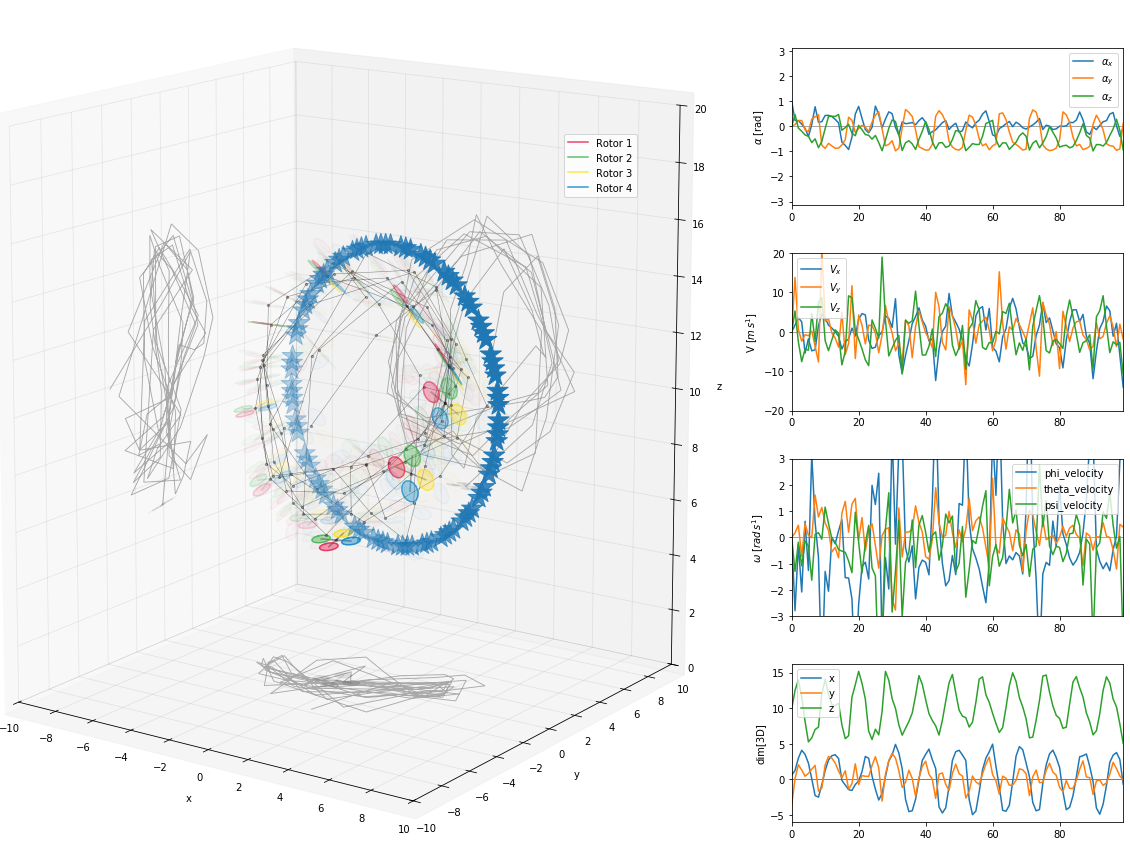

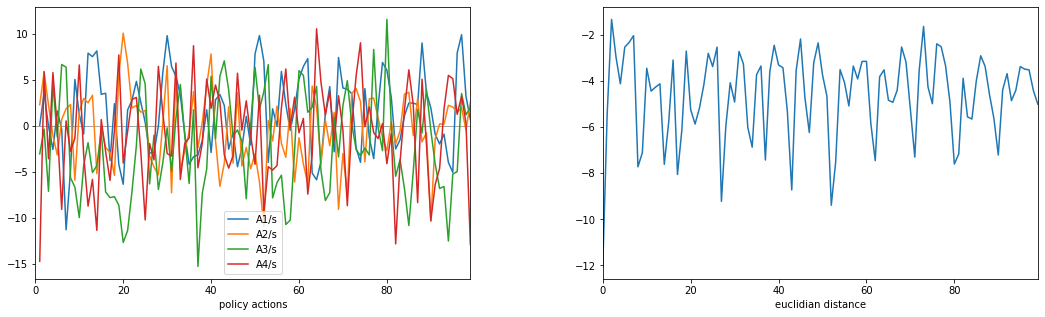

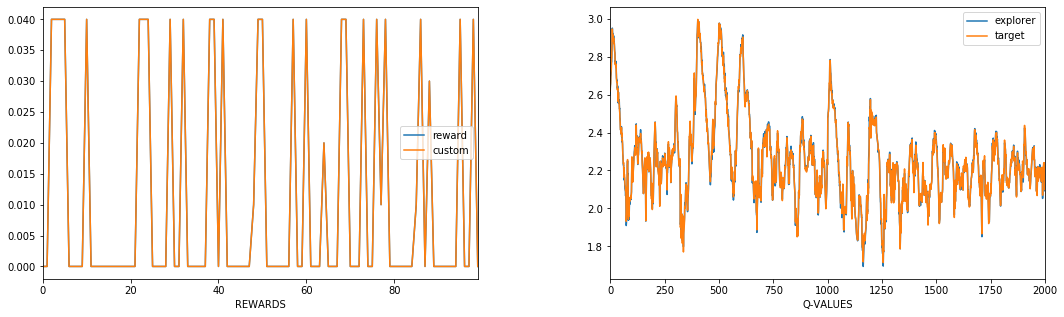

[ 1399> 83939:: 0] steps =   59, max_step =  60/ 60, reward=1.596000 <action=tensor([-8.2039, -4.0437,  7.7106,  0.8777])>                                    
 environment solved!  31.429799297489218 [array([31.5022493, 31.3573493])]
[[tensor(29.2315), tensor(32.6625), tensor(30.1345), tensor(32.6315), tensor(31.7490), tensor(30.3050), tensor(33.4560), tensor(31.5025), tensor(31.8235), tensor(31.5265)], [tensor(31.4925), tensor(31.2365), tensor(31.6070), tensor(30.7605), tensor(29.5175), tensor(31.7330), tensor(31.5195), tensor(31.7490), tensor(32.3825), tensor(31.5755)]]

	 [ 1399 ] < 17528.69 sec > TEST ==>  [[tensor(29.2315), tensor(32.6625), tensor(30.1345), tensor(32.6315), tensor(31.7490), tensor(30.3050), tensor(33.4560), tensor(31.5025), tensor(31.8235), tensor(31.5265)], [tensor(31.4925), tensor(31.2365), tensor(31.6070), tensor(30.7605), tensor(29.5175), tensor(31.7330), tensor(31.5195), tensor(31.7490), tensor(32.3825), tensor(31.5755)]] exploring score: tensor(1.6300)
timeb

In [10]:
agent, env = new_agent(
#    [4, 1], bpo_brain, lr_critic=5e-5,
    [0, 0], bpo_brain, lr_critic=5e-5,
    goal_encoder=goal_encoder, encoder=encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

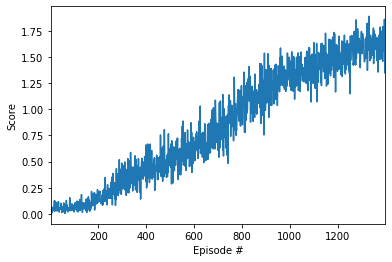

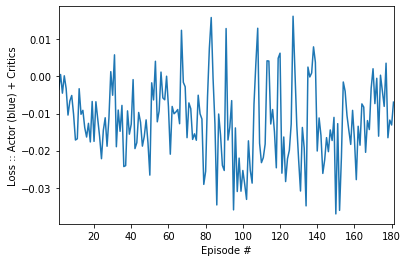

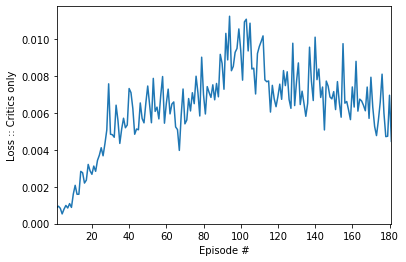

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  31.127224304252287 [array([31.07834931, 31.1760993 ])]
[[tensor(31.2540), tensor(30.2410), tensor(31.3845), tensor(31.2790), tensor(30.8165), tensor(31.1765), tensor(29.9960), tensor(31.4390), tensor(31.4970), tensor(31.7000)], [tensor(30.7015), tensor(31.8890), tensor(28.2405), tensor(29.7025), tensor(32.3035), tensor(31.9270), tensor(30.5550), tensor(32.8645), tensor(32.5405), tensor(31.0370)]]

 environment solved!  31.23082430193665 [array([30.88044931, 31.58119929])]
[[tensor(30.6190), tensor(29.9415), tensor(30.9310), tensor(29.7965), tensor(29.6170), tensor(30.3470), tensor(30.4365), tensor(32.5025), tensor(33.0515), tensor(31.5620)], [tensor(31.8920), tensor(31.9105), tensor(32.4145), tensor(32.2740), tensor(31.8035), tensor(29.4030), tensor(33.3390), tensor(30.5795), tensor(30.1405), tensor(32.0555)]]

 environment solved!  31.10534930474123 [array([31.2516993 , 30.95899931])]
[[tensor(28.3910), tensor(31.8995), tensor(32.3980), tensor(30.9925), tensor(3

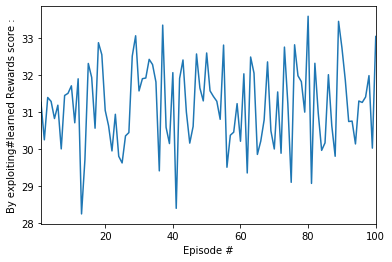

In [14]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for score in scores ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  29.8572743326379 [array([30.55494932, 29.15959935])]
[[tensor(31.6900), tensor(33.0090), tensor(29.2320), tensor(30.7045), tensor(30.8270), tensor(30.9055), tensor(29.0285), tensor(30.5730), tensor(28.4845), tensor(31.0955)], [tensor(27.9395), tensor(27.0445), tensor(32.5275), tensor(28.2800), tensor(29.0725), tensor(26.8360), tensor(29.0140), tensor(29.3315), tensor(31.0085), tensor(30.5420)]]

 environment solved!  30.073049327814964 [array([29.97584933, 30.17024933])]
[[tensor(31.7855), tensor(30.8385), tensor(27.3630), tensor(29.1015), tensor(30.8230), tensor(30.0040), tensor(30.9815), tensor(27.6695), tensor(32.4315), tensor(28.7605)], [tensor(31.5570), tensor(31.4915), tensor(29.9875), tensor(30.4485), tensor(31.4745), tensor(28.9980), tensor(29.3055), tensor(30.4600), tensor(27.3595), tensor(30.6205)]]

 environment solved!  30.278849323214974 [array([30.68079931, 29.87689933])]
[[tensor(30.2170), tensor(31.3240), tensor(31.4615), tensor(30.8280), tensor(3

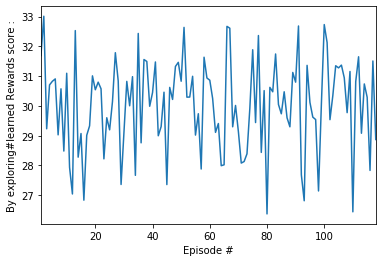

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for score in scores ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()